# Single Fault Experiment

## Setup - Install / Import packages, Import files / Connect to Drive

### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### Install packages

In [ ]:
pip install ruptures pyod combo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 KB 20.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.0.7-py3-none-any.whl size=181101 sha256=75137314ef6f7a2cd1b504b5dc4965e3973c2bad4da543adadd6e8cdfea8eb4d
  Stored in directory: /root/.cache/pip/wheels/f7/e2/c1/1c7fd8b261e72411f6509afb429c84532e40ddcd96074473f4
  Created wheel for combo: filename=combo-0.1.3-py3-none-any.whl size=42885 sha256=8dde53bd3e37fab49bac2d4fbb41b1d931b688232e1b512a1bf2c6505d16bec7
  Stored in directory: /root/.cache/pip/wheels/ec/44/39/0667fea44a2dfe692cc2a51f0f79ea49b9dee7def53594ef2e
Successfully built pyod combo


### Import packages

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve,roc_auc_score
import pandas as pd
import numpy as np
'''
# Pyod imports 
from pyod.models.ecod import ECOD
from pyod.models.abod import ABOD
from pyod.models.lunar import LUNAR
from pyod.models.vae import VAE
from pyod.models.alad import ALAD
from pyod.models.deep_svdd import DeepSVDD
from pyod.models.knn import KNN
# Ruptures imports
import ruptures as rpt
'''
# Proposed Imports
import torch
from tqdm import trange
import tqdm
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import logging


### Import pipeline steps

In [ ]:
from detector import *
from preprocess import * 

### Load Proposed Model

In [ ]:
model = AnomalyDetector()
model= torch.load('/content/b256_e10000_h25.pth')


## Preprocess Example

In [ ]:
train_link = "/content/drive/My Drive/TEPdata/experiment_1/normal_10000.csv"
test_link = "/content/drive/My Drive/TEPdata/experiment_1/df_IDV(8).csv"


processor = DataProcessor(train_link, test_link, "Fault", "Unnamed: 0")
X_train = processor.X_train
y_train = processor.y_train
X_test = processor.X_test
y_test = processor.y_test
scaler = processor.scaler_function

## Shared Functions

### Evaluation / Helper Functions

In [ ]:
def _precision(tp, fp):
    '''
    Precision = TP / (TP + FP)
    :param tp: True Positive
    :param fp: False Positive
    :return: precision
    
    Usage of the function:
    -> _precision(10, 5)
    '''
    pre = tp / float(tp + fp)
    return pre


def _recall(tp, fn):
    '''
    Recall = TP / (TP + FN)
    :param tp: True Positive
    :param fn: False Negative
    :return: recall

    Usage of the function:
    -> _recall(10, 5)
    '''
    rec = tp / float(tp + fn)
    return rec


def _f1(pre, rec):
    '''
    F1 = 2 * (Precision * Recall) / (Precision + Recall)
    :param pre: Precision
    :param rec: Recall
    :return: F1 Score
    
    Usage of the function:
    -> _f1(0.5, 0.5)
    '''
    f1 = 2 * (pre * rec) / (pre + rec)
    return f1


def print_results(accuracy, pre, rec, f1, roc):
    '''
    Print the results of the model
    :param accuracy: Accuracy of the model
    :param pre: Precision of the model
    :param rec: Recall of the model
    :param f1: F1 Score of the model
    :param roc: ROC AUC Score of the model
    :return: None
    
    Usage of the function:
    -> print_results(0.5, 0.5, 0.5, 0.5, 0.5)
    '''
    print("Accuracy: {}%".format(round(accuracy * 100, 2)))
    print("Precision: {}%".format(round(pre * 100, 2)))
    print("Recall: {}%".format(round(rec * 100, 2)))
    print("F1 Score: {}%".format(round(f1 * 100, 2)))
    print("ROCAUC: {}%".format(round(roc * 100, 2)))

def _results(accuracy, pre, rec, f1,roc):
    '''
    Function to calculate the results
    :param accuracy: accuracy score
    :param pre: precision score
    :param rec: recall score
    :param f1: f1 score
    :param roc: roc_auc score
    :return: accuracy, precision, recall, f1, roc_auc
    
    Usage:
    >> acc,precision, recall, f1_score, roc_auc = _results(accuracy, precision, recall , f1, roc)
    '''
    acc = round(accuracy*100,2)
    precision = round(pre*100,2)
    recall = round(rec*100,2)
    f1_score = round(f1*100,2)
    roc_auc = round(roc*100,2)
    return [acc,precision, recall, f1_score, roc_auc]

def calculate_results_return(y_test, y_pred):
    '''
    Function to calculate the results
    :param y_test: test data
    :param y_pred: predicted data
    :return: accuracy, precision, recall, f1, roc_auc
    
    Usage:
    >> acc,precision, recall, f1_score, roc_auc = calculate_results(y_test, y_pred)
    '''
    cm = confusion_matrix(y_test, y_pred)
    TP = cm[0,0]
    TN = cm[1,1]
    FP = cm[0,1]
    FN = cm[1,0]
    accuracy = accuracy_score(y_test, y_pred)
    precision = _precision(TP,FP)
    recall = _recall(TP,FN)
    f1 = _f1(precision,recall)
    roc = roc_auc_score(y_test, y_pred)
    acc,precision, recall, f1_score, roc_auc = _results(accuracy, precision, recall , f1, roc)
    return [acc,precision, recall, f1_score, roc_auc]

def result_dataframe(result_dict, y_test,fault):
    '''
    Function to create a dataframe of the results
    :param result_dict: dictionary of the results
    :param y_test: test data
    :param fault: fault type
    :return: dataframe of the results
    
    Usage:
    >> df = result_dataframe(result_dict, y_test, fault)
    '''
    df = pd.DataFrame()
    for model in result_dict:
        res = calculate_results_return(y_test,  result_dict[model])
        df = df.append({"Fault": fault,'Model' : model, 'Accuracy': res[0], 'Precision': res[1], 'Recall': res[2], 'F1 Score': res[3], 'ROCAUC': res[4]}, ignore_index=True)
    return df

def join_df(df_list):
    '''
    Function to join the dataframes
    :param df_list: list of dataframes
    :return: joined dataframe
    
    Usage:
    >> df = join_df(df_list)
    '''
    df = pd.concat(df_list, ignore_index=True)
    return df

def fault_name(link):
    '''
    Function to get the fault name
    :param link: link to the fault
    :return: fault name
    
    Usage:
    >> fault = fault_name(link)
    '''
    parts = link.split('/')
    filename = parts[-1]  # get the last part of the split string, which is the file name
    idv = filename.split('_')[-1].split('.')[0]  # get the last part before the '.'
    return idv

def convert_dict_to_df(dictionary,y_true, fault):
    '''
    Function to convert the dictionary to a dataframe
    :param dictionary: dictionary of the results
    :param y_true: true labels
    :param fault: fault name
    :return: dataframe of the results
    
    Usage:
    >> df = convert_dict_to_df(dictionary,y_true, fault)
    '''
    dictionary["y_true"] = y_true
    df=pd.DataFrame.from_dict(dictionary,orient='index').transpose()
    df["Fault"] = fault
    return df

from joblib import dump, load
def dump_model(path, model, name):
    dump(model, '/{}/{}.joblib'.format(path,name))

def load_model(path, name):
    return load('/{}/{}.joblib'.format(path,name))

    

## Pipelines

### Proposed Model Pipeline

In [ ]:
def find_optimal_threshold(y_test, y_pred):
        '''
        :param y_test: test target variable
        :param y_pred: predicted target variable
        :return: optimal threshold
        '''
        # get the false positive rate, true positive rate and thresholds
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        # get the optimal threshold based on the maximum tpr - fpr
        optimal_idx = np.argmax(tpr - fpr)
        # get the optimal threshold
        optimal_threshold = thresholds[optimal_idx]
        return optimal_threshold

def convert_scores_to_label(array, threshold):
    '''
    The function converts the scores to labels based on the threshold, if the score is greater than the threshold,
    the label is 1, else 0
    :param array: array of scores
    :param threshold: threshold to use for converting the scores to labels
    :return: array of labels
    '''
    binary = []
    for i in array:
        if i < threshold:
            binary.append(0)
        else:
            binary.append(1)
    return binary



def run_experiment_lstm(link_test, y_test):
    '''
    Function to run the experiment
    :param link_test: link to the test data
    :param y_test: test data
    :return: dataframe of the results
    '''
    # get the fault name
    fname = fault_name(link_test) 
    # create a DataProcessor object
    processor = DataProcessor(train_link, link_test, "Fault", "Unnamed: 0") 
    X_train = processor.X_train
    y_train = processor.y_train
    x_test = processor.X_test
    y_test = processor.y_test

    def test_models(x_test):
        # predict the data
        yp, det = model.predict(x_test)
        # find the optimal threshold
        optimal = find_optimal_threshold(y_test, yp)
        # convert the scores to labels
        y_pred = convert_scores_to_label(yp, optimal) 
        results = {}
        results["Proposed Model"] = y_pred
        return results

    # get the results
    result_dict = test_models(x_test)
    # get the predictions
    predictions = result_dict 
    # get the true labels
    predictions["y_true"] = list(y_test)
    # get the dataframe of the results
    result = result_dataframe(result_dict, y_test, fname)
    return result, result_dict 

### PYOD Pipelines

In [ ]:
pyod_models = {"ECOD": ECOD(),
           "ABOD":ABOD(),
           "LUNAR": LUNAR(n_epochs = 400),
           "VAE": VAE(epochs = 200), 
           "ALAD": ALAD(epochs = 1000),
           "DeepSVDD" : DeepSVDD(epochs = 200),
           "KNN": KNN(method = "mean") }

ecod = load_model("/content/", "ECOD")
abod = load_model("/content/", "ABOD")
lunar = load_model("/content/", "LUNAR")
#vae = load_model("/content/", "ECOD")
alad = load_model("/content/", "ALAD")
deepsvdd = load_model("/content/", "DeepSVDD")
knn = load_model("/content/", "KNN")


trained_pyod = {"ECOD": ecod,
           "ABOD":abod,
           "LUNAR": lunar, 
           "ALAD": alad,
           "DeepSVDD" : deepsvdd,
           "KNN": knn}


def train_models_pyod(x_train, methods):
    '''
    Function to train the models
    :param x_train: train data
    :param methods: list of models
    :return: dictionary of the models

    Usage:
    >> models = train_models_pyod(x_train, methods)
    '''
    trained = {}
    for model in methods:
        methods[model].fit(x_train)
        trained[model] = methods[model]
    return trained


import pandas as pd


def run_experiment_pyod(link_test, y_test, models):
    '''
    Function to run the experiment
    :param link_test: link to the test data
    :param y_test: test data
    :param models: list of models
    :return: dataframe of the results

    Usage:
    >> df = run_experiment_pyod(link_test, y_test, models)
    '''
    # get the fault name
    fname = fault_name(link_test)
    # create a DataProcessor object
    processor = DataProcessor(train_link, link_test, "Fault", "Unnamed: 0")
    X_train = processor.X_train
    y_train = processor.y_train
    x_test = processor.X_test
    y_test = processor.y_test

    def test_models(x_test, models):
        '''
        Function to test the models
        :param x_test: test data
        :param models: list of models
        :return: dictionary of the results

        Usage:
        >> results = test_models(x_test, models)
        '''
        results = {}
        for model in models:
            y_pred = models[model].predict(x_test)
            results[model] = list(y_pred)

        return results

    result_dict = test_models(x_test, models)
    predictions = result_dict
    predictions["y_true"] = list(y_test)
    result = result_dataframe(result_dict, y_test, fname)
    return result, predictions

### Ruptures Pipeline

In [ ]:

models_cp = {'PELT': rpt.KernelCPD(kernel="rbf", min_size=2),
             "BottomUp": rpt.detection.bottomup.BottomUp(model = "rbf")}


def run_experiment_ruptures(link_test, y_test, models, penalty):
    '''
    Function to run the experiment
    :param link_test: link to the test data
    :param y_test: test data
    :param models: list of models
    :param penalty: penalty
    :return: dataframe of the results
    
    Usage:
    >> df = run_experiment_ruptures(link_test, y_test, models, penalty)
    '''
    fname = fault_name(link_test)
    processor = DataProcessor(train_link, link_test, "Fault", "Unnamed: 0")
    X_train = processor.X_train
    y_train = processor.y_train
    x_test = processor.X_test
    y_test = processor.y_test

    def train_models(x_test, models, penalty):
        '''
        Function to train the models
        :param x_test: test data
        :param models: list of models
        :param penalty: penalty
        
        Usage:
        >> trained = train_models(x_test, models, penalty)
        :return: 
        '''
        test_length = len(x_test)
        results = {}
        for model in models:
            models[model].fit(x_test.values)
            bkps = models[model].predict(pen=penalty)
            if len(bkps) % 2 != 0:
                bkps.pop()
            y_pred = [0] * test_length
            for i in range(0, len(bkps), 2):
                for j in range(bkps[i], bkps[i + 1] + 1):
                    if j < test_length:
                        y_pred[j] = 1

            results[model] = y_pred
        return results

    result_dict = train_models(x_test, models, penalty)
    predictions = result_dict
    predictions["y_true"] = list(y_test)
    result = result_dataframe(result_dict, y_test, fname)
    return result, predictions

## Call Functions

### Proposed Model Calls

In [ ]:
# Run experiment on each Test Set
results_lstm_idv1,y_preds_idv1 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(1).csv",y_test)
results_lstm_idv2,y_preds_idv2 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(2).csv",y_test)
results_lstm_idv3,y_preds_idv3 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(3).csv",y_test)
results_lstm_idv4,y_preds_idv4 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(4).csv",y_test)
results_lstm_idv5,y_preds_idv5 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(5).csv",y_test)
results_lstm_idv6,y_preds_idv6 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(6).csv",y_test)
results_lstm_idv7,y_preds_idv7 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(7).csv",y_test)
results_lstm_idv8,y_preds_idv8 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(8).csv",y_test)
results_lstm_idv9,y_preds_idv9 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(9).csv",y_test)
results_lstm_idv10,y_preds_idv10 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(10).csv",y_test)
results_lstm_idv11,y_preds_idv11 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(11).csv",y_test)
results_lstm_idv12,y_preds_idv12 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(12).csv",y_test)
results_lstm_idv13,y_preds_idv13 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(13).csv",y_test)
results_lstm_idv14,y_preds_idv14 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(14).csv",y_test)
results_lstm_idv15,y_preds_idv15 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(15).csv",y_test)
results_lstm_idv16,y_preds_idv16 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(16).csv",y_test)
results_lstm_idv17,y_preds_idv17 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(17).csv",y_test)
results_lstm_idv18,y_preds_idv18 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(18).csv",y_test)
results_lstm_idv19,y_preds_idv19 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(19).csv",y_test)
results_lstm_idv20,y_preds_idv20 = run_experiment_lstm("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(20).csv",y_test)

# Convert Labels to a Dataframe
y_preds_idv1 = convert_dict_to_df(y_preds_idv1,y_test, "IDV(1)")
y_preds_idv2 = convert_dict_to_df(y_preds_idv2,y_test, "IDV(2)")
y_preds_idv3 = convert_dict_to_df(y_preds_idv3,y_test, "IDV(3)")
y_preds_idv4 = convert_dict_to_df(y_preds_idv4,y_test, "IDV(4)")
y_preds_idv5 = convert_dict_to_df(y_preds_idv5,y_test, "IDV(5)")
y_preds_idv6 = convert_dict_to_df(y_preds_idv6,y_test, "IDV(6)")
y_preds_idv7 = convert_dict_to_df(y_preds_idv7,y_test, "IDV(7)")
y_preds_idv8 = convert_dict_to_df(y_preds_idv8,y_test, "IDV(8)")
y_preds_idv9 = convert_dict_to_df(y_preds_idv9,y_test, "IDV(9)")
y_preds_idv10 = convert_dict_to_df(y_preds_idv10,y_test, "IDV(10)")
y_preds_idv11 = convert_dict_to_df(y_preds_idv11,y_test, "IDV(11)")
y_preds_idv12 = convert_dict_to_df(y_preds_idv12,y_test, "IDV(12)")
y_preds_idv13 = convert_dict_to_df(y_preds_idv13,y_test, "IDV(13)")
y_preds_idv14 = convert_dict_to_df(y_preds_idv14,y_test, "IDV(14)")
y_preds_idv15 = convert_dict_to_df(y_preds_idv15,y_test, "IDV(15)")
y_preds_idv16 = convert_dict_to_df(y_preds_idv16,y_test, "IDV(16)")
y_preds_idv17 = convert_dict_to_df(y_preds_idv17,y_test, "IDV(17)")
y_preds_idv18 = convert_dict_to_df(y_preds_idv18,y_test, "IDV(18)")
y_preds_idv19 = convert_dict_to_df(y_preds_idv19,y_test, "IDV(19)")
y_preds_idv20 = convert_dict_to_df(y_preds_idv20,y_test, "IDV(20)")

### PYOD Calls

In [ ]:
results_pyod_idv1,pyod_idv1 = run_experiment_pyod("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(1).csv",y_test, trained_pyod)
results_pyod_idv2,pyod_idv2 = run_experiment_pyod("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(2).csv",y_test, trained_pyod)
results_pyod_idv3,pyod_idv3 = run_experiment_pyod("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(3).csv",y_test, trained_pyod)
results_pyod_idv4,pyod_idv4 = run_experiment_pyod("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(4).csv",y_test, trained_pyod)
results_pyod_idv5,pyod_idv5 = run_experiment_pyod("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(5).csv",y_test, trained_pyod)
results_pyod_idv6,pyod_idv6 = run_experiment_pyod("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(6).csv",y_test, trained_pyod)
results_pyod_idv7,pyod_idv7 = run_experiment_pyod("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(7).csv",y_test, trained_pyod)
results_pyod_idv8,pyod_idv8 = run_experiment_pyod("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(8).csv",y_test, trained_pyod)
results_pyod_idv9,pyod_idv9 = run_experiment_pyod("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(9).csv",y_test, trained_pyod)
results_pyod_idv10,pyod_idv10 = run_experiment_pyod("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(10).csv",y_test, trained_pyod)
results_pyod_idv11,pyod_idv11 = run_experiment_pyod("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(11).csv",y_test, trained_pyod)
results_pyod_idv12,pyod_idv12 = run_experiment_pyod("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(12).csv",y_test, trained_pyod)
results_pyod_idv13,pyod_idv13 = run_experiment_pyod("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(13).csv",y_test, trained_pyod)
results_pyod_idv14,pyod_idv14 = run_experiment_pyod("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(14).csv",y_test, trained_pyod)
results_pyod_idv15,pyod_idv15 = run_experiment_pyod("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(15).csv",y_test, trained_pyod)
results_pyod_idv16,pyod_idv16 = run_experiment_pyod("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(16).csv",y_test, trained_pyod)
results_pyod_idv17,pyod_idv17 = run_experiment_pyod("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(17).csv",y_test, trained_pyod)
results_pyod_idv18,pyod_idv18 = run_experiment_pyod("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(18).csv",y_test, trained_pyod)
results_pyod_idv19,pyod_idv19 = run_experiment_pyod("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(19).csv",y_test, trained_pyod)
results_pyod_idv20,pyod_idv20 = run_experiment_pyod("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(20).csv",y_test, trained_pyod)


pyod_idv1 = convert_dict_to_df(pyod_idv1,y_test, "IDV(1)")
pyod_idv2 = convert_dict_to_df(pyod_idv2,y_test, "IDV(2)")
pyod_idv3 = convert_dict_to_df(pyod_idv3,y_test, "IDV(3)")
pyod_idv4 = convert_dict_to_df(pyod_idv4,y_test, "IDV(4)")
pyod_idv5 = convert_dict_to_df(pyod_idv5,y_test, "IDV(5)")
pyod_idv6 = convert_dict_to_df(pyod_idv6,y_test, "IDV(6)")
pyod_idv7 = convert_dict_to_df(pyod_idv7,y_test, "IDV(7)")
pyod_idv8 = convert_dict_to_df(pyod_idv8,y_test, "IDV(8)")
pyod_idv9 = convert_dict_to_df(pyod_idv9,y_test, "IDV(9)")
pyod_idv10 = convert_dict_to_df(pyod_idv10,y_test, "IDV(10)")
pyod_idv11 = convert_dict_to_df(pyod_idv11,y_test, "IDV(11)")
pyod_idv12 = convert_dict_to_df(pyod_idv12,y_test, "IDV(12)")
pyod_idv13 = convert_dict_to_df(pyod_idv13,y_test, "IDV(13)")
pyod_idv14 = convert_dict_to_df(pyod_idv14,y_test, "IDV(14)")
pyod_idv15 = convert_dict_to_df(pyod_idv15,y_test, "IDV(15)")
pyod_idv16 = convert_dict_to_df(pyod_idv16,y_test, "IDV(16)")
pyod_idv17 = convert_dict_to_df(pyod_idv17,y_test, "IDV(17)")
pyod_idv18 = convert_dict_to_df(pyod_idv18,y_test, "IDV(18)")
pyod_idv19 = convert_dict_to_df(pyod_idv19,y_test, "IDV(19)")
pyod_idv20 = convert_dict_to_df(pyod_idv20,y_test, "IDV(20)")

313/313 [==============================] - 0s 1ms/step


### Ruptures Calls

In [ ]:
results_rpt_idv1, rpt_idv1 = run_experiment_ruptures("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(1).csv",y_test, models_cp,20)
results_rpt_idv2, rpt_idv2 = run_experiment_ruptures("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(2).csv",y_test, models_cp,20)
results_rpt_idv3, rpt_idv3 = run_experiment_ruptures("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(3).csv",y_test, models_cp,20)
results_rpt_idv4, rpt_idv4 = run_experiment_ruptures("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(4).csv",y_test, models_cp,20)
results_rpt_idv5, rpt_idv5 = run_experiment_ruptures("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(5).csv",y_test, models_cp,20)
results_rpt_idv6, rpt_idv6 = run_experiment_ruptures("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(6).csv",y_test, models_cp,20)
results_rpt_idv7, rpt_idv7 = run_experiment_ruptures("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(7).csv",y_test, models_cp,20)
results_rpt_idv8, rpt_idv8 = run_experiment_ruptures("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(8).csv",y_test, models_cp,20)
results_rpt_idv9, rpt_idv9 = run_experiment_ruptures("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(9).csv",y_test, models_cp,20)
results_rpt_idv10, rpt_idv10 = run_experiment_ruptures("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(10).csv",y_test, models_cp,20)
results_rpt_idv11, rpt_idv11 = run_experiment_ruptures("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(11).csv",y_test, models_cp,20)
results_rpt_idv12, rpt_idv12 = run_experiment_ruptures("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(12).csv",y_test, models_cp,20)
results_rpt_idv13, rpt_idv13 = run_experiment_ruptures("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(13).csv",y_test, models_cp,20)
results_rpt_idv14, rpt_idv14 = run_experiment_ruptures("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(14).csv",y_test, models_cp,20)
results_rpt_idv15, rpt_idv15 = run_experiment_ruptures("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(15).csv",y_test, models_cp,20)
results_rpt_idv16, rpt_idv16 = run_experiment_ruptures("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(16).csv",y_test, models_cp,20)
results_rpt_idv17, rpt_idv17 = run_experiment_ruptures("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(17).csv",y_test, models_cp,20)
results_rpt_idv18, rpt_idv18 = run_experiment_ruptures("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(18).csv",y_test, models_cp,20)
results_rpt_idv19, rpt_idv19 = run_experiment_ruptures("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(19).csv",y_test, models_cp,20)
results_rpt_idv20, rpt_idv20 = run_experiment_ruptures("/content/drive/My Drive/TEPdata/experiment_1/df_IDV(20).csv",y_test, models_cp,20)

rpt_idv1 = convert_dict_to_df(rpt_idv1,y_test, "IDV(1)")
rpt_idv2 = convert_dict_to_df(rpt_idv2,y_test, "IDV(2)")
rpt_idv3 = convert_dict_to_df(rpt_idv3,y_test, "IDV(3)")
rpt_idv4 = convert_dict_to_df(rpt_idv4,y_test, "IDV(4)")
rpt_idv5 = convert_dict_to_df(rpt_idv5,y_test, "IDV(5)")
rpt_idv6 = convert_dict_to_df(rpt_idv6,y_test, "IDV(6)")
rpt_idv7 = convert_dict_to_df(rpt_idv7,y_test, "IDV(7)")
rpt_idv8 = convert_dict_to_df(rpt_idv8,y_test, "IDV(8)")
rpt_idv9 = convert_dict_to_df(rpt_idv9,y_test, "IDV(9)")
rpt_idv10 = convert_dict_to_df(rpt_idv10,y_test, "IDV(10)")
rpt_idv11 = convert_dict_to_df(rpt_idv11,y_test, "IDV(11)")
rpt_idv12 = convert_dict_to_df(rpt_idv12,y_test, "IDV(12)")
rpt_idv13 = convert_dict_to_df(rpt_idv13,y_test, "IDV(13)")
rpt_idv14 = convert_dict_to_df(rpt_idv14,y_test, "IDV(14)")
rpt_idv15 = convert_dict_to_df(rpt_idv15,y_test, "IDV(15)")
rpt_idv16 = convert_dict_to_df(rpt_idv16,y_test, "IDV(16)")
rpt_idv17 = convert_dict_to_df(rpt_idv17,y_test, "IDV(17)")
rpt_idv18 = convert_dict_to_df(rpt_idv18,y_test, "IDV(18)")
rpt_idv19 = convert_dict_to_df(rpt_idv19,y_test, "IDV(19)")
rpt_idv20 = convert_dict_to_df(rpt_idv20,y_test, "IDV(20)")

## Make Dataframes

### Proposed Model Dataframes

#### Aggregated Results

In [ ]:
results_all_lstm = join_df([results_lstm_idv1, results_lstm_idv2, results_lstm_idv3, results_lstm_idv4, results_lstm_idv5,
                            results_lstm_idv6, results_lstm_idv7, results_lstm_idv8, results_lstm_idv9, results_lstm_idv10,
                            results_lstm_idv11, results_lstm_idv12, results_lstm_idv13, results_lstm_idv14, results_lstm_idv15,
                            results_lstm_idv16, results_lstm_idv17, results_lstm_idv18, results_lstm_idv19, results_lstm_idv20
                            ])


results_lstm_15_types = join_df([results_lstm_idv1, results_lstm_idv2, results_lstm_idv4, results_lstm_idv5,
                            results_lstm_idv6, results_lstm_idv8, results_lstm_idv10,
                            results_lstm_idv11, results_lstm_idv13, results_lstm_idv14,
                            results_lstm_idv16, results_lstm_idv17, results_lstm_idv19, results_lstm_idv20
                            ])

#### Raw Results

In [ ]:
results_pred_lstm_all = join_df([y_preds_idv1, y_preds_idv2, y_preds_idv3, y_preds_idv4, y_preds_idv5,
                                 y_preds_idv6, y_preds_idv7, y_preds_idv8, y_preds_idv9, y_preds_idv10,
                                 y_preds_idv11, y_preds_idv12, y_preds_idv13, y_preds_idv14, y_preds_idv15,
                                 y_preds_idv16, y_preds_idv17, y_preds_idv18, y_preds_idv19, y_preds_idv20])

results_pred_lstm_15 = join_df([y_preds_idv1, y_preds_idv2, y_preds_idv4, y_preds_idv5,
                                 y_preds_idv6, y_preds_idv8, y_preds_idv10,
                                 y_preds_idv11, y_preds_idv13, y_preds_idv14,
                                 y_preds_idv16, y_preds_idv17, y_preds_idv19, y_preds_idv20])

### PYOD Dataframes

#### Aggregated Results

In [ ]:
result_pyod_all = join_df([results_pyod_idv1, results_pyod_idv2, results_pyod_idv3, results_pyod_idv4, results_pyod_idv5,
                  results_pyod_idv6, results_pyod_idv7, results_pyod_idv8, results_pyod_idv9, results_pyod_idv10,
                  results_pyod_idv11, results_pyod_idv12, results_pyod_idv13, results_pyod_idv14, results_pyod_idv15,
                  results_pyod_idv16, results_pyod_idv17, results_pyod_idv18, results_pyod_idv19, results_pyod_idv20,
                  ])

result_pyod_15 = join_df([results_pyod_idv1, results_pyod_idv2, results_pyod_idv4, results_pyod_idv5,
                  results_pyod_idv6, results_pyod_idv8, results_pyod_idv10,
                  results_pyod_idv11, results_pyod_idv13, results_pyod_idv14,
                  results_pyod_idv16, results_pyod_idv17, results_pyod_idv19, results_pyod_idv20,
                  ])

#### Raw Results

In [ ]:
result_pyod_pred_all = join_df([pyod_idv1, pyod_idv2, pyod_idv3, pyod_idv4, pyod_idv5,
                  pyod_idv6, pyod_idv7, pyod_idv8, pyod_idv9, pyod_idv10,
                  pyod_idv11, pyod_idv12, pyod_idv13, pyod_idv14, pyod_idv15,
                  pyod_idv16, pyod_idv17,pyod_idv18, pyod_idv19, pyod_idv20,
                  ])

result_pyod_pred_15 = join_df([pyod_idv1, pyod_idv2, pyod_idv4, pyod_idv5,
                  pyod_idv6, pyod_idv8, pyod_idv10,
                  pyod_idv11, pyod_idv13, pyod_idv14,
                  pyod_idv16, pyod_idv17, pyod_idv19, pyod_idv20,
                  ])

### Ruptures Dataframes

#### Aggregated Results

In [ ]:
results_rpt_all = join_df([results_rpt_idv1, results_rpt_idv2, results_rpt_idv3, results_rpt_idv4, results_rpt_idv5, 
                   results_rpt_idv6, results_rpt_idv7, results_rpt_idv8, results_rpt_idv9, results_rpt_idv10, 
                   results_rpt_idv11, results_rpt_idv12, results_rpt_idv13, results_rpt_idv14, results_rpt_idv15, 
                   results_rpt_idv16, results_rpt_idv17, results_rpt_idv18, results_rpt_idv19, results_rpt_idv20])

results_rpt_15 = join_df([results_rpt_idv1, results_rpt_idv2, results_rpt_idv4, results_rpt_idv5, 
                   results_rpt_idv6, results_rpt_idv8, results_rpt_idv10, 
                   results_rpt_idv11, results_rpt_idv13, results_rpt_idv14, 
                   results_rpt_idv16, results_rpt_idv17, results_rpt_idv19, results_rpt_idv20])

#### Raw Results

In [ ]:
results_rpt_pred_all = join_df([rpt_idv1, rpt_idv2, rpt_idv3, rpt_idv4, rpt_idv5, 
                   rpt_idv6, rpt_idv7, rpt_idv8, rpt_idv9, rpt_idv10, 
                   rpt_idv11, rpt_idv12, rpt_idv13, rpt_idv14, rpt_idv15, 
                   rpt_idv16, rpt_idv17, rpt_idv18, rpt_idv19, rpt_idv20])

results_rpt_pred_15 = join_df([rpt_idv1, rpt_idv2, rpt_idv4, rpt_idv5, 
                   rpt_idv6, rpt_idv8, rpt_idv10, 
                   rpt_idv11, rpt_idv13, rpt_idv14, 
                   rpt_idv16, rpt_idv17, rpt_idv19, rpt_idv20])

In [ ]:
results_rpt_15

,Fault,Model,Accuracy,Precision,Recall,F1 Score,ROCAUC
0,IDV(1),PELT,48.30,47.36,89.05,61.83,51.42
1,IDV(1),BottomUp,57.16,57.11,91.14,70.22,57.33
2,IDV(1),y_true,100.00,100.00,100.00,100.00,100.00
3,IDV(2),PELT,61.11,62.91,90.13,74.10,55.14
4,IDV(2),BottomUp,57.16,57.11,91.14,70.22,57.33
5,IDV(2),y_true,100.00,100.00,100.00,100.00,100.00
6,IDV(4),PELT,99.03,99.89,99.02,99.45,96.18
7,IDV(4),BottomUp,57.16,57.11,91.14,70.22,57.33
8,IDV(4),y_true,100.00,100.00,100.00,100.00,100.00
9,IDV(5),PELT,86.37,87.50,96.77,91.91,82.60


## Save Results

In [ ]:
results_rpt_all.to_csv("experiment_results_rpt_all.csv")
results_rpt_15.to_csv("experiment_results_rpt_15.csv")

In [ ]:
# Proposed Model Results



results_lstm_15_types.to_csv("experiment_results_lstm_15_types.csv")
results_all_lstm.to_csv("experiment_results_all_lstm.csv")
results_pred_lstm_15.to_csv("experiment_results_lstm_15_pred.csv")
results_all_lstm.to_csv("experiment_results_pred_lstm_all.csv")


# PYOD Results
result_pyod_all.to_csv("experiment_result_pyod_all.csv")
result_pyod_15.to_csv("experiment_result_pyod_15.csv")
result_pyod_pred_all.to_csv("experiment_result_pyod_pred_all.csv")
result_pyod_all.to_csv("experiment_result_pyod_pred_15.csv")

# Ruptures Results
results_rpt_all.to_csv("experiment_results_rpt_all.csv")
results_rpt_15.to_csv("experiment_results_rpt_15.csv")
results_rpt_pred_all.to_csv("experiment_results_rpt_pred_all.csv")
results_rpt_pred_15.to_csv("experiment_results_rpt_pred_15.csv")

# Multi Fault

In [ ]:
train_link = "/content/drive/My Drive/TEPdata/experiment_1/normal_10000.csv"
test_link = "/content/drive/My Drive/TEPdata/experiment_2/TEP_multi_attack_offical.csv"


processor = DataProcessor(train_link, test_link, "Fault", "Unnamed: 0")
X_train = processor.X_train
y_train = processor.y_train
X_test = processor.X_test
y_test = processor.y_test
scaler = processor.scaler_function

In [ ]:
y_pred, det = model.predict(X_test)


/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,roc_auc_score
import seaborn as sns

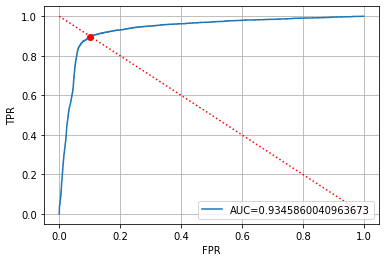

array([42.43748211])

In [ ]:
def ROC(y_test,y_pred):
    fpr,tpr,tr=roc_curve(y_test,y_pred)
    auc=roc_auc_score(y_test,y_pred)
    idx=np.argwhere(np.diff(np.sign(tpr-(1-fpr)))).flatten()

    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.plot(fpr,1-fpr,'r:')
    plt.plot(fpr[idx],tpr[idx], 'ro')
    plt.legend(loc=4)
    plt.grid()
    plt.show()
    return tr[idx]

ROC(y_test,y_pred)

In [ ]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

0.9345860040963673
Threshold value is: 43.16794142061655


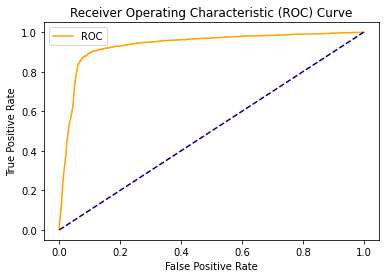

In [ ]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.savefig("roc_multi.png", transparent  = False)
    plt.show()

#y_true = y_test[10:len(aa)]
#y_scores = aa[10:len(aa)]
y_true = y_test
y_scores = y_pred

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
print(roc_auc_score(y_true, y_scores))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)

# CVAE

In [ ]:
from typing import Sequence

import numpy as np
import pandas as pd


import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [ ]:
pip install salesforce-merlion

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 KB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 9.8 MB/s eta 0:00:00


In [ ]:
from salesforce_merlion import ts_datasets


ModuleNotFoundError: ignored

In [ ]:
from merlion.utils import TimeSeries
from ts_datasets.anomaly import NAB

ModuleNotFoundError: ignored

In [ ]:
from merlion.evaluate.anomaly import NAB

ImportError: ignored

In [ ]:
import ts_datasets

ModuleNotFoundError: ignored

In [ ]:
pip install ts-datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement ts-datasets (from versions: none)
ERROR: No matching distribution found for ts-datasets
